In [1]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
import numpy as np
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio import Entrez
from Bio import SeqIO
from io import StringIO
import matplotlib.pyplot as plt
import re
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import copy
import time
from scipy.integrate import solve_ivp
import os

In [23]:
L= 0.05 # module length in meters
n_f = 9 #number of fibers
A = 0.0030 #m2
h = 0.4e-3 #m
w = 7e-3 #m

delta_membrane = 0.125e-3 #m
p_s = 0.2e-6 #pore size in meters
T = 277.15 #K
R = 8.314 #J/mol/K
F = 96485 #C/mol
e = 1.60217662e-19 #C
porosity = 0.70

X = 1

pH =7

I = 180 #ionic strength mM
permitivity = 6.375e-10 #permitivity of the medium C^2(J.m)^-1
# gamma_w = 32400#shear rate s-1
phi_m = 0.64
eta_0 = 0.001#Pa.second viscosity of 
rho_p = 1400 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant



# Particle sizes (in meters)
particles = [
    {'name': '5nm', 'radius': 5e-9, 'phi_b': 7.81e-05*X},
    {'name': '40nm', 'radius': 40e-9, 'phi_b': 0.00012496*X},
    {'name': '70nm', 'radius': 70e-9, 'phi_b': 0.000461*0.710*X},
    {'name': '120nm', 'radius': 120e-9, 'phi_b': 0.000426*0.710*X},
    {'name': '190nm', 'radius': 190e-9, 'phi_b': 0.000220*0.710*X},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.000176*0.710*X},
    {'name': '700nm', 'radius': 700e-9, 'phi_b': 0.000154*0.710*X},
    {'name': '2500nm', 'radius': 2500e-9, 'phi_b': 0.000154*0.710*X},
]

phi_bulk = sum(particles[i]['phi_b'] for i in range(len(particles)))

phi_w_guess = [0.64] * len(particles)


In [24]:
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    
    eta_phi = eta_0*(1+(5/2)*phi_b+k1*(phi_b**2))
    return eta_phi
  

def max_agg_packing (phi_m):
    phi_Max=phi_m+phi_m*(1-phi_m)+0.74*(1- (phi_m+ phi_m*(1-phi_m)))
    return phi_Max
phi_M = max_agg_packing(phi_m)

eta_f = viscosity_no_PP(eta_0, sum(particle['phi_b'] for particle in particles), 10)


def J_brownian(a, phi_w, phi_b,gamma_w):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    if phi_w == 0:
         J=0
  
    else:
         J = 0.114 * term * (math.log((abs(phi_w / phi_b))))
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b,gamma_w):
    term = (a ** 4 / L) ** (1/3)
    log_term = (abs(phi_w / phi_b))
    if phi_w == 0:
            J=0
    elif phi_bulk <0.1:
            J = 0.126 * term * gamma_w * (log_term)**(1/3)
    else:
     
        J = 0.078 * term * gamma_w * abs(math.log(log_term))

    return J

#J solvent permeation flux (m/s)


def get_protein_info(uniprot_code, pH):
    Entrez.email = "s230152@dtu.dk"
    handle = Entrez.esearch(db="protein", term=uniprot_code, retmax=1)
    record = Entrez.read(handle)
    handle.close()

    protein_id = record["IdList"][0]

    handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
    record = handle.read()
    handle.close()

    seq_record = SeqIO.read(StringIO(record), "genbank")
    protein_sequence = seq_record.seq
    protein = IP(protein_sequence)

    iep = protein.pi()
    net_charge = protein.charge_at_pH(pH)

    return iep, net_charge
uniprot_code = {a:uniprot_code for a,uniprot_code in zip([particle['name'] for particle in particles],['P42212','P0A910','P0A7K6','P0CE47','P0A825','P0A9X4','P0A9A6','P0A940'])}
net_charge = {}
# 
for particle in particles:
    _, net_charge[particle['name']]  = get_protein_info(uniprot_code[particle['name']], pH)


L_p= 55/3600/1000/1000   
s = (( 5*eta_f* delta_membrane * L_p) /porosity)**(1/2)
k = (((permitivity*R*T)/(((F**2)*(2*I))))**(1/2))
lambda_aph_dict={}
for particle,charge in zip(particles,net_charge.values()):
        z = charge
        phi_b = particle['phi_b']
        a = particle['radius']
        lambda_aph = 1 - math.exp(-a/(2*s))
        delta_s = ((z)*e)/(4*math.pi*(a**2))
        eff_a = a + (((4*(a**3)*(delta_s**2))/(permitivity*k_B*T))*0.2*k)
        particle["radius"]=eff_a
        lambda_aph_dict[eff_a] = lambda_aph

phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}


In [16]:

def min_flux(Particles, phi_w_list,gamma_w):
    """ have to put particles list with radius and phi_b,
    phi_w_list with phi_w
    results ai_target, J_flux and dataframe"""
    set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])
    # velocities_list = []
    min_velocity = float('inf')
    selected_particle_radius = None

    for particle, phi_w in zip(Particles, phi_w_list):
        
            a = particle['radius']
            phi_b = particle['phi_b']
            
            
            # Calculate velocities
            brownian_velocity = J_brownian(a, phi_w, phi_b,gamma_w)
            shear_velocity = J_shear(a, phi_w, phi_b,gamma_w)
        
            
            # Find the maximum velocity
            max_velocity = max(brownian_velocity,  shear_velocity)
            
            # Determine the source of the maximum velocity
            source = 'brownian' if max_velocity == brownian_velocity  else 'shear'
            
            # Update set_data by replacing previous row or adding a new one
            if particle['name'] in set_data['name'].values:
                set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
            else:
                set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
          
          
            if phi_w !=0:
            # Check for the minimum velocity
                if max_velocity < min_velocity:
                    min_velocity = max_velocity
                    selected_particle_radius = a
            

    return selected_particle_radius, min_velocity, set_data

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data,gamma_w):
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            max_velocity = data.loc[data['radius'] == a_particle, 'max_velocity'].values[0]
            if max_velocity >= 10 * min_velocity or max_velocity == 0:
                # Handle inertial particles
                phi_w_dict[a_particle] = 0
            else:
                def objective_function(phi_w_particle):
                    max_velocity = max(J_brownian(a_particle, phi_w_particle, phi_b_particle,gamma_w),J_shear(a_particle, phi_w_particle, phi_b_particle,gamma_w))
                    return abs(max_velocity - min_velocity)
            
        #     # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal

                else:
                    pass

    return phi_w_dict

# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
def packing_constraints(Particles, phi_w_list,gamma_w):
    ai_target, min_vel, dataf= min_flux(Particles, phi_w_list,gamma_w)
    phi_w_dict=calculate_phi_w(Particles, ai_target, min_vel, dataf,gamma_w)

    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 50
    
    for i in range(max_iterations):
        phi_w_dict_1 = {a: phi_w for a, phi_w in phi_w_dict.items() if phi_w > 0}

        max_key = max(phi_w_dict_1.keys())
        min_key = min(phi_w_dict_1.keys())
        
        # Check if the ratio between the max and min keys is within the thresholds
        if 100>(max_key / min_key )>= 10:
            phi_w_a1 = {a: phi_w for a, phi_w in phi_w_dict_1.items() if max_key >= a >= max_key / 10}
            phi_w_a2 = {a: phi_w for a, phi_w in phi_w_dict_1.items() if max_key / 10 > a >= max_key / 100}

            # Check if conditions on sums of phi_w for different ranges hold
            if (0.9064) >= sum(phi_w_dict.values()) and \
               (sum(phi_w_a1.values()) <= 0.64) and \
               (sum(phi_w_a2.values()) <= 0.74 * (1 - sum(phi_w_a1.values()))):
       
                return phi_w_dict, min_vel
            phi_w_previous = phi_w_dict.copy()
            # Update phi_w for the target particle
           
            phi_w_dict[ai_target] = (0.9064) * (phi_w_dict[ai_target] / sum(phi_w_dict.values()))
        
            ai_target, min_vel, dataf= min_flux(particles, phi_w_dict.values(),gamma_w)
            # min_vel = dataf.loc[dataf['radius'] == ai_target, 'max_velocity'].values[0]
            phi_w_dict=calculate_phi_w(particles, ai_target, min_vel, dataf,gamma_w)
        
            # Check for the change in phi_w values between iterations
            phi_w_diff = sum(abs(phi_w_dict[a] - phi_w_previous[a]) for a in phi_w_dict)
            
            if phi_w_diff < tolerance:
        
                return phi_w_dict,   min_vel
        elif (max_key / min_key )<10:
            
            if (0.68 >= sum(phi_w_dict.values())):
                return phi_w_dict, min_vel
            phi_w_previous = phi_w_dict.copy()
            # Update phi_w for the target particle
         
            phi_w_dict[ai_target] = (0.68* (phi_w_dict[ai_target] / sum(phi_w_dict.values())))
       
            ai_target, min_vel ,dataf= min_flux(particles, phi_w_dict.values(),gamma_w)
            # min_vel = dataf.loc[dataf['radius'] == ai_target, 'max_velocity'].values[0]
            phi_w_dict=calculate_phi_w(particles, ai_target, min_vel, dataf,gamma_w)
        
            # Check for the change in phi_w values between iterations
            phi_w_diff = sum(abs(phi_w_dict[a] - phi_w_previous[a]) for a in phi_w_dict)
            
            # If the change in phi_w values is smaller than the tolerance, stop the iteration
            if phi_w_diff < tolerance:
                return phi_w_dict,   min_vel
        elif (max_key / min_key )>=100:
            # Adjust the calculation for this case
            phi_w_a1 = {a: phi_w for a, phi_w in phi_w_dict_1.items() if max_key >= a >= max_key / 10}
            phi_w_a2 = {a: phi_w for a, phi_w in phi_w_dict_1.items() if max_key / 10 > a >= max_key / 100}
            phi_w_a3 = {a: phi_w for a, phi_w in phi_w_dict_1.items() if max_key / 100 > a }
        
            if (phi_M >= sum(phi_w_dict.values())) and \
               (sum(phi_w_a1.values()) <= 0.64) and \
               (sum(phi_w_a2.values()) <= 0.64 * (1 - sum(phi_w_a1.values()))) and \
               sum(phi_w_a3.values()) <= 0.74 * (1 - (sum(phi_w_a1.values()) + sum(phi_w_a2.values()))):
                return phi_w_dict, min_vel
            phi_w_previous = phi_w_dict.copy()
            # Update phi_w for the target particle
         
            phi_w_dict[ai_target] = (phi_M * (phi_w_dict[ai_target] / sum(phi_w_dict.values())))
       
            ai_target, min_vel ,dataf= min_flux(particles, phi_w_dict.values(),gamma_w)
            # min_vel = dataf.loc[dataf['radius'] == ai_target, 'max_velocity'].values[0]
            phi_w_dict=calculate_phi_w(particles, ai_target, min_vel, dataf,gamma_w)
        
            # Check for the change in phi_w values between iterations
            phi_w_diff = sum(abs(phi_w_dict[a] - phi_w_previous[a]) for a in phi_w_dict)
            
            # If the change in phi_w values is smaller than the tolerance, stop the iteration
            if phi_w_diff < tolerance:
                return phi_w_dict,   min_vel
    return phi_w_dict, min_vel

def J_flux_calculation(Particles, phi_w_list,gamma_w):
    # Unpack the results from packing_constraints
    phi_w_dict, J_flux = packing_constraints(Particles, phi_w_list,gamma_w)
    # print(phi_w_dict)
    phi_w_dict_copy = copy.deepcopy(phi_w_dict)
    # Initialize J_pi with J_flux values from packing constraints for all particles
    J_pi = {a: J_flux for a in phi_w_dict.keys()}
    
    phi_w_dict_T = {}
    phi_w_dict_R = {}
    # Separate phi_w values into two dictionaries based on particle size comparison with p_s/2
    for (a, phi_w) in phi_w_dict.items():
        
        if a <= p_s / 2:
            phi_w_dict_T[a] = phi_w
            # print(phi_w_dict_T)
        else:
            phi_w_dict_R[a] = phi_w
            # print(phi_w_dict_R)

    # Update phi_w for particles in phi_w_dict_T based on ratio of min(phi_w_dict_R.keys()) / a
    for (a, phi_w) in phi_w_dict_T.items():
        if (min(phi_w_dict_R.keys()) / a )< 10:
            phi_w_dict_copy[a] = 0.64 * (1 - sum(phi_w_dict_R.values()))
        else:
            phi_w_dict_copy[a] = 0.74 * (1 - sum(phi_w_dict_R.values()))
       
    
    # Calculate J_pi only for particles in phi_w_dict_T
    for a , particle in zip(phi_w_dict_T.keys(), Particles):
        phi_b = particle['phi_b']
        
   
            # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w_dict_copy[a], phi_b, gamma_w)
        shear_velocity = J_shear(a, phi_w_dict_copy[a], phi_b, gamma_w)


        # Update J_pi with the maximum velocity for particles in phi_w_dict_T
        max_velocity = max(brownian_velocity, shear_velocity)
        if max_velocity< J_pi[a]:
            pass
        else:
            
            J_pi[a] = max_velocity
                
    return J_pi, phi_w_dict, J_flux

#mass-transfer coefficient calculated from equation  1#step 10


def sieving_parameters(Particles, phi_w_list,gamma_w):
    
    J_pi,phi_w_dict, J_flux = J_flux_calculation(Particles, phi_w_list,gamma_w)
    S_oi_dep = {a: (1-(J_actual / J_pi[a])) for a in phi_w_dict.keys()}
    S_oi_membrane = {a: 0 for a in phi_w_dict.keys()}
    S_oi = {a: 0 for a in phi_w_dict.keys()}
    for particle,phi_w in zip(Particles,phi_w_dict.values()):
        phi_b = particle['phi_b']
        a = particle['radius']
        if phi_w == 0:
            S_oi[a] = S_oi_dep[a] * S_oi_membrane[a]
        else:
        
            lambda_aph =lambda_aph_dict[a]
            # print(f"lambda_aph: {lambda_aph}")
            diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * a)
            mass_transfer_k = J_pi[a]/math.log(abs(phi_w/phi_b))
        
            Sieving_coeff_int = ((1 - lambda_aph) ** 2) * (2 - ((1 - lambda_aph) ** 2)) * math.exp(-0.7146 * (lambda_aph ** 2))
            # print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
            phi_e_K_d = (1 - lambda_aph) ** (9 / 2)
            # print(f"phi_e_K_d: {phi_e_K_d}")
            Peclet_m = ((J_actual * (delta_membrane)) / diffusion_coeff) * (Sieving_coeff_int / (porosity * phi_e_K_d))
          
            if Peclet_m >709:
                Sieving_coeff_act = Sieving_coeff_int
            else:
                Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
                
            # print(f"Actual Sieving coefficient: {Sieving_coeff_act}")
            Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act) * math.exp(-J_actual / mass_transfer_k) + Sieving_coeff_act)
            # print(f"Sieving coefficient: {Sieving_coeff_obs}")
            S_oi_membrane[a] = Sieving_coeff_obs
            S_oi[a] = S_oi_dep[a] * S_oi_membrane[a]
            if S_oi[a] < 0 and S_oi[a] > -0.1:
                S_oi[a] =abs( S_oi[a])
            elif S_oi[a] < -0.1:
                S_oi[a] = 0
   
    return J_flux, S_oi, phi_w_dict



In [5]:
# 
# Save the initial values of particles and phi_w_dict
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
particles_initial = copy.deepcopy(particles)
phi_w_dict_initial = copy.deepcopy(phi_w_dict)
phi_b1_initial = np.array([p['phi_b'] for p in particles])  # Initial retentate concentrations
phi_b2_initial = np.zeros(len(particles))  # Initial permeate concentrations

total_time = 10000  # Total simulation time in seconds
V_2 = 100e-6  # Maximum permeate volume (m³)
V_1 = 50e-6   # Feed volume (m³)
V2 =0
# Initialize V2 globally before the simulation
 # Initial volume of permeate in the reservoir
V2_max = V_2  # Maximum volume of permeate the reservoir can hold
time_step = 10  # Time step in seconds
sieving_coefficients =[]
times = []
phi_w =[]
J_flux_list =[]
# Function to calculate concentration dynamics
def concentration_dynamics(t, y):
   
    # Split retentate and permeate concentrations
    N = len(particles)
    
    phi_b1 = y[:N]# Retentate concentrations
    phi_b2 = y[N:2*N]# Permeate concentrations
    V2 = y[-1]
    # Update particle data
    for i, p in enumerate(particles):
        p['phi_b'] = phi_b1[i]
    eta_f = viscosity_no_PP(eta_0, sum(p['phi_b'] for p in particles), 10)

    Q = (Re * eta_f* w )/ (rho_f )
    gamma_w = (6 * Q)  / ((h**2)*w)
   
# Recalculate sieving coefficients and other parameters
    J_flux, S_oi_dict,_ = sieving_parameters(particles, phi_w_dict.values(),gamma_w)
    J_flux_list.append(J_flux)
    
    S_oi = np.array([S_oi_dict.get(p['radius'], 0) for p in particles]) # Extract sieving coefficients
    sieving_coefficients.append((S_oi))  # Append sieving coefficients for each particle
    times.append(t)

    phi_w.append((np.array([phi_w_dict.get(p['radius'], 0) for p in particles])))
    # Calculate derivatives for retentate and permeate
    dphi_b1_dt = np.zeros(len(particles))
    dphi_b2_dt = np.zeros(len(particles))

    for i, p in enumerate(particles):
        
        # Retentate dynamics
        dphi_b1_dt[i] = (((A * J_actual * (- S_oi[i])))* phi_b1[i])/ V_1 + (A * J_actual * phi_b2[i]) / V_1
        # Permeate dynamics
        dphi_b2_dt[i] = (A * J_actual * S_oi[i] * phi_b1[i]) / V_2 - (A * J_actual * phi_b2[i]) / V_2
        dV2_dt = A * J_actual

    dydt = np.concatenate([dphi_b1_dt, dphi_b2_dt, [dV2_dt]])
    return dydt

# Initial conditions
# 
V2_initial = 0
y0 = np.concatenate([phi_b1_initial, phi_b2_initial, [V2_initial]])

def simulate_process(J_actual):
    global sieving_coefficients
    global phi_w
    global J_flux_list

    # Reset global storage
    sieving_coefficients = []
    phi_w = []
    J_flux_list = []
    # Solve the system of ODEs
    solution = solve_ivp(
        concentration_dynamics,
        t_span=(0, total_time),
        y0=y0,
        method='L',
        t_eval=np.arange(0, total_time + time_step, time_step)
    )

    # Extract results
    time_points = solution.t
    phi_b1_solution = solution.y[:len(particles), :].T
    phi_b2_solution = solution.y[len(particles):2*len(particles), :].T
    V2_solution = solution.y[-1, :].T

    # Calculate cumulative yield as (phi_b2 * V_2) / (phi_b1_initial * V_1)
    yield_fraction = (phi_b2_solution * V_2) / (phi_b1_initial * V_1)
   

    
    # Store results
    results_df = pd.DataFrame({'Time (s)': time_points})
    for i, p in enumerate(particles):
        results_df[f'{p["radius"]}_retentate'] = phi_b1_solution[:, i]
        results_df[f'{p["name"]}_permeate'] = phi_b2_solution[:, i]
        results_df[f'{p["name"]}_cumulative_yield'] = yield_fraction[:, i]
        # results_df[f'{p["name"]}_sieving_coefficient'] = np.array(sieving_coefficients)[:, i]


    results_df['V2_{V_2}'] = V2_solution
    results_df["Added Buffer"] = results_df['V2_{V_2}']
    results_df["Diavolumes"] = results_df["Added Buffer"] / V_1
    # Split phi_w and sieving coefficients into separate columns in the results dataframe
    # Add sieving coefficients to the results dataframe
    sieving_df = pd.DataFrame(sieving_coefficients, columns=[f'{p["name"]}_sieving_coefficient' for p in particles])
    sieving_df['Time (s)'] = times[:len(sieving_df)]
    sieving_df['J_flux'] = J_flux_list[:len(sieving_df)]
    phi_w_array = np.array(phi_w)
    for i, p in enumerate(particles):
        sieving_df[f'{p["name"]}_phi_w' ] = phi_w_array[:len(sieving_df), i]
 
    return results_df,  sieving_df



In [ ]:
Re_list = list(range(1,245,15))
for i in Re_list:
    Re = i 
    particles = copy.deepcopy(particles_initial)
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    eta_f = viscosity_no_PP(eta_0, sum(p['phi_b'] for p in particles), 10)
    Q = (Re * eta_f* w )/ (rho_f )
    gamma_w = (6 * Q)  / ((h**2)*w)
    
    
    J_actual = 0.5/ 3600 / 1000
    J_PD, _, _ = sieving_parameters(particles, phi_w_guess,gamma_w)
  
    J_increment = J_PD / 10
    while J_actual <= J_PD*1.1:
        # Start timing the iteration
        start_time = time.time()

        # Reset particles and phi_w_dict to their initial values
        particles = copy.deepcopy(particles_initial)
        phi_w_dict = copy.deepcopy(phi_w_dict_initial)

        try:
            # Run the simulation
            results_df, sieving_df= simulate_process(J_actual)

            # If yield reaches 95%, store results
        # Create folder name
            folder_name = f'GFP_Model_X_{X}_pH_{pH}_I_{I}_3/GFP_Model_gamma_w_{gamma_w:.2f}_J_PD_{J_PD*3600*1000:.2f}'
            os.makedirs(folder_name, exist_ok=True)

            # Save results for this iteration with J_actual in the filename
            results_df.to_csv(f'{folder_name}/dynamic_simulation_J_actual_{J_actual*3600*1000:.2f}_Re{Re}.csv', index=False)
            sieving_df.to_csv(f'{folder_name}/sieving_coefficients_J_actual_{J_actual*3600*1000:.2f}_Re{Re}.csv', index=False)  

        except Exception as e:
            import traceback
            print(f"Error during simulation for J_actual = {J_actual*100:.4e}: {e}")
            traceback.print_exc()
        end_time = time.time()
        print(f"Iteration with J_actual = {J_actual*3600*1000} completed in {(end_time - start_time):.2f} seconds and")

        
        if i ==1:
                break
        # Increment J_actual for the next iteration
        J_actual += J_increment
        i = 0
        if J_actual <1.1 * J_PD and J_actual>=J_PD:
            J_actual = J_PD *0.95
            i +=1


In [27]:
data_figs_2=pd.DataFrame(columns=['shear_rate', 'J_pred_5nm', 'J_pred_40nm', 'J_pred_70nm', 'J_pred_120nm', 'J_pred_190nm','J_pred_320nm', 'J_pred_700nm', 'J_pred_2500nm'])           
flux_dict_2 ={}
gamma_w =list(range(600,9000,400))   
for i in gamma_w:
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = i #shear rate s-1

    _, J_flux, set_datas=min_flux(particles, phi_w_guess,gamma_w )
    data_figs_2.loc[i] = [gamma_w, set_datas.loc[0, 'max_velocity'], set_datas.loc[1, 'max_velocity'], set_datas.loc[2, 'max_velocity'], set_datas.loc[3, 'max_velocity'], set_datas.loc[4, 'max_velocity'], set_datas.loc[5, 'max_velocity'], set_datas.loc[6, 'max_velocity'], set_datas.loc[7, 'max_velocity']]
    flux_dict_2[i]= J_flux

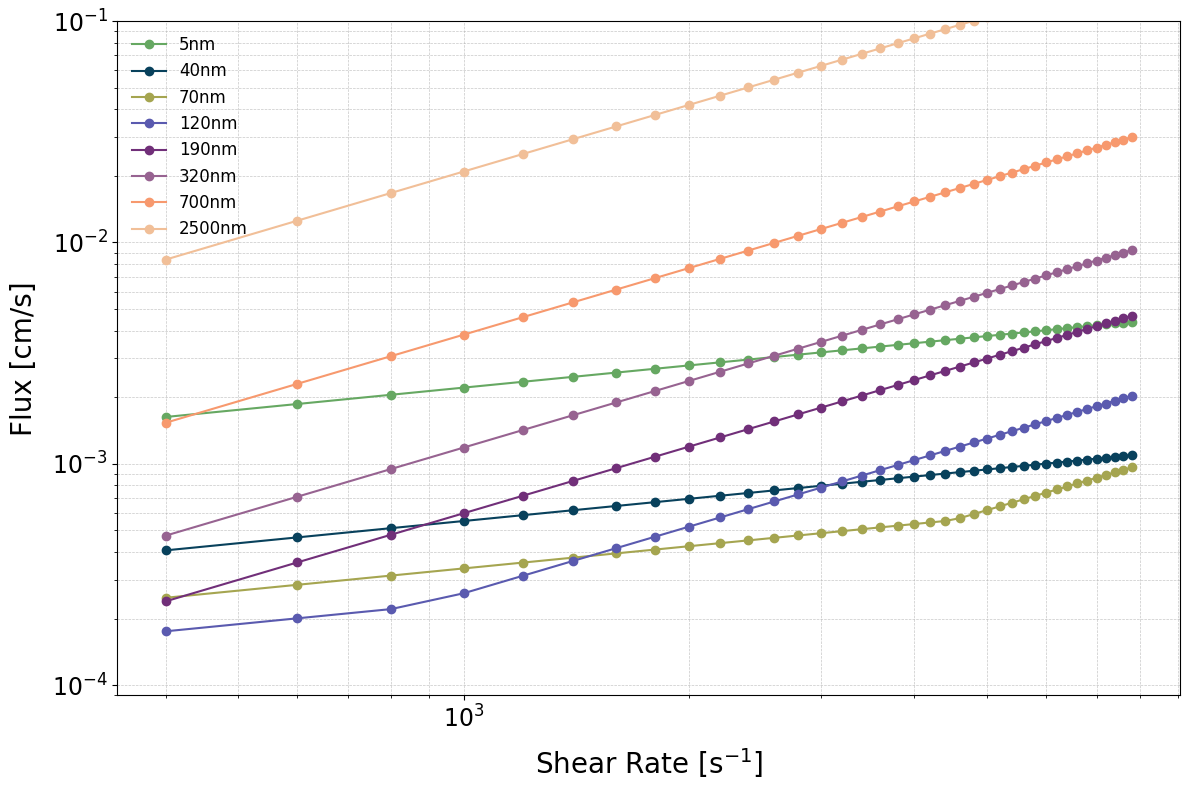

In [13]:
import matplotlib.pyplot as plt

# Define the hex color codes
colors = ['#66a862', '#08415C', '#a5a550', '#5A5AAF', '#712F79', 
          '#976391', '#F7996E', '#F1BF98', '#EEE5E9']

# Plot the data
plt.figure(figsize=(12, 8))

# Plot each line with specified colors
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_5nm']*100, marker='o', linestyle='-', label='5nm', color=colors[0])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_40nm']*100, marker='o', linestyle='-', label='40nm', color=colors[1])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_70nm']*100, marker='o', linestyle='-', label='70nm', color=colors[2])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_120nm']*100, marker='o', linestyle='-', label='120nm', color=colors[3])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_190nm']*100, marker='o', linestyle='-', label='190nm', color=colors[4])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_320nm']*100, marker='o', linestyle='-', label='320nm', color=colors[5])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_700nm']*100, marker='o', linestyle='-', label='700nm', color=colors[6])
plt.plot(data_figs_2['shear_rate'], data_figs_2['J_pred_2500nm']*100, marker='o', linestyle='-', label='2500nm', color=colors[7])

# Add labels, title, and legend
plt.xlabel('Shear Rate [s$^{-1}$]', fontsize=20, labelpad=10)
plt.ylabel('Flux [cm/s]', fontsize=20, labelpad=10)
plt.tick_params(axis='both', labelsize=17)


# Customize legend
plt.legend(fontsize=12,  title_fontsize=14, loc='upper left', frameon=False)

# Adjust y-axis and x-axis scales and limits
plt.ylim(9e-5, 1e-1)
plt.xscale('log')
plt.yscale('log')

# Customize grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust tick parameters


# Add tight layout for better spacing
plt.tight_layout()
plt.savefig('J_pred_vs_Shear_Rate.png', dpi=300)
# Show the plot
plt.show()
# Save the figure


In [21]:
data_figs_10X=pd.DataFrame(columns=['shear_rate', 'J_pred_5nm', 'J_pred_40nm', 'J_pred_70nm', 'J_pred_120nm', 'J_pred_190nm','J_pred_320nm', 'J_pred_700nm', 'J_pred_2500nm'])           
flux_dict_10X ={}
gamma_w =list(range(600,9000,400))   
for i in gamma_w:
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = i #shear rate s-1

    _, J_flux, set_datas=min_flux(particles, phi_w_guess,gamma_w )
    data_figs_10X.loc[i] = [gamma_w, set_datas.loc[0, 'max_velocity'], set_datas.loc[1, 'max_velocity'], set_datas.loc[2, 'max_velocity'], set_datas.loc[3, 'max_velocity'], set_datas.loc[4, 'max_velocity'], set_datas.loc[5, 'max_velocity'], set_datas.loc[6, 'max_velocity'], set_datas.loc[7, 'max_velocity']]
    flux_dict_10X[i]= J_flux

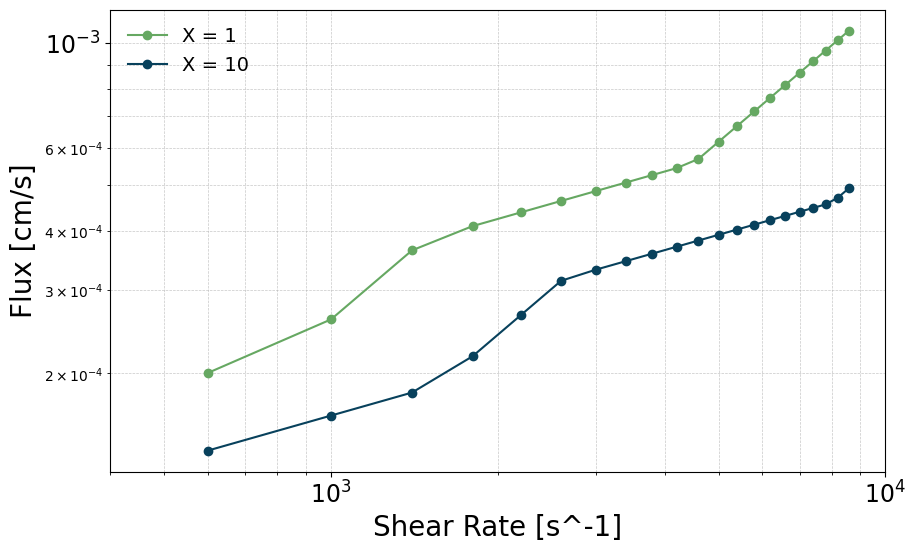

In [28]:
# Extract shear rates and corresponding J_flux values from flux_dict_1
shear_rates = list(flux_dict_2.keys())
j_flux_values = [value * 100 for value in flux_dict_2.values()]
shear_rates_10X= list(flux_dict_10X.keys())
j_flux_values_10X = [value * 100 for value in flux_dict_10X.values()]
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(shear_rates, j_flux_values, marker='o', linestyle='-', label='X = 1',color='#66a862')
plt.plot(shear_rates_10X, j_flux_values_10X, marker='o', linestyle='-', label='X = 10',color='#08415C')

# Add labels, title, and legend
plt.xlabel('Shear Rate [s^-1]',fontsize=20)
plt.ylabel('Flux [cm/s]',fontsize=20)
plt.tick_params(axis='both', labelsize=17)

plt.legend(fontsize=14, loc='upper left', frameon=False)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim(400, 10000)
plt.yscale('log')
plt.xscale('log')

# Show the plot
plt.show()